<a href="https://colab.research.google.com/github/alvitay/Forcasting-consumer-price-index/blob/main/Forcasting_Consumer_price_index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-------------------------------------------------------------------------------
# **Forecasting Consumer Price Index**
-------------------------------------------------------------------------------

---------------------------
## **Objective**
---------------------------

The objective of this problem statement is to build a time series model that can forecast the consume price index (CPI) for the next 5 years.

In [1]:
!pip install statsmodels==0.14.2

In [2]:
# Version check
import statsmodels

statsmodels.__version__

'0.14.2'

In [3]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [5]:
# Mount your drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
ps_cpi = pd.read_csv('/content/drive/MyDrive/Forcasting consumer price index/PriceStats_CPI.csv')

ps_cpi.head()

,date,PriceStats,CPI
0,24-07-2008,100.00000,100.0
1,25-07-2008,99.99767,100.0
2,26-07-2008,99.92376,100.0
3,27-07-2008,99.91537,100.0
4,28-07-2008,99.89491,100.0


**Observation:**

We can see that while PriceStats changes daily, the CPI only changes monthly. Hence, the monthly CPI can be obtained by taking the CPI of any day during a month.

Let's first convert the date column into datetime format

In [7]:
ps_cpi['date'] = pd.to_datetime(ps_cpi['date'],dayfirst=True)

ps_cpi.head()

,date,PriceStats,CPI
0,2008-07-24,100.00000,100.0
1,2008-07-25,99.99767,100.0
2,2008-07-26,99.92376,100.0
3,2008-07-27,99.91537,100.0
4,2008-07-28,99.89491,100.0


In [8]:
# PriceStats has a daily variation whereas the CPI data changes monthly
cpi_monthly = pd.DataFrame(columns = ['Month','CPI'])

ps_cpi['YearMonth'] = ps_cpi['date'].dt.strftime('%Y - %m')

In [9]:
cpi = ps_cpi.drop_duplicates('YearMonth', keep = 'last').copy().reset_index().drop(['index','PriceStats'], axis = 1)

Splitting the data into train and test sets

In [10]:
cpi_train = (cpi[cpi.YearMonth < '2013-09'].copy())

cpi_test = (cpi[cpi.YearMonth >= '2013-09'].copy())

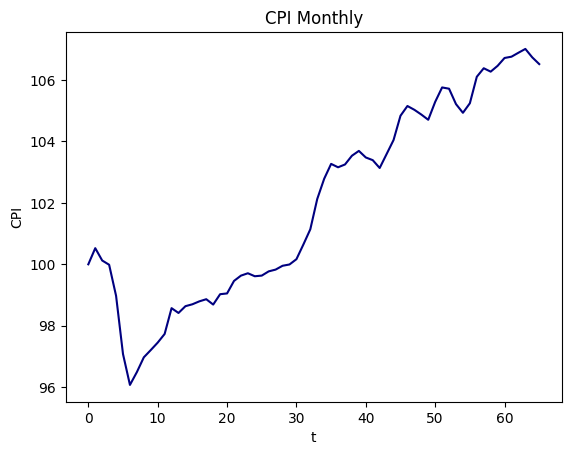

In [11]:
# Let's visualize the time series

plt.plot(cpi_train.index, cpi_train.CPI, color = 'navy')

plt.xlabel('t')

plt.ylabel('CPI')

plt.title('CPI Monthly')

plt.show()

From the visualization, it is clear that the time series has a deterministic trend. We will try and fit a linear model to
the data and see if that is sufficient to represent the trend. We then subtract this trend from the data.

The linear trend is given by F(t) = 0.16009489280868378*t + (96.74978204432384)


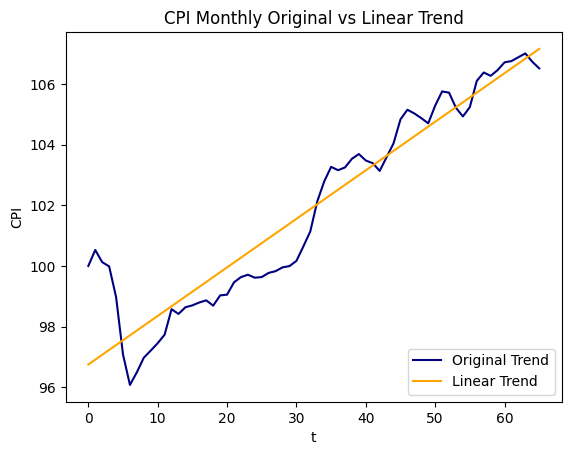

In [12]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(np.array(cpi_train.index).reshape(-1, 1), cpi_train.CPI)

coefficients = [model.coef_[0], model.intercept_]

print("The linear trend is given by F(t) = " +str(coefficients[0]) + "*t + (" +str (coefficients[1]) + ")")

linear_cpi = model.predict(np.array(cpi_train.index).reshape(-1, 1))

plt.plot(cpi_train.index, cpi_train.CPI, color = 'navy', label = 'Original Trend')

plt.xlabel('t')

plt.ylabel('CPI')

plt.title('CPI Monthly Original vs Linear Trend')

plt.plot(cpi_train.index, linear_cpi, color = 'orange', label = 'Linear Trend')

plt.legend(loc = 'lower right')

plt.show()

In [13]:
x = input('Choose Method:')

Choose Method:linear


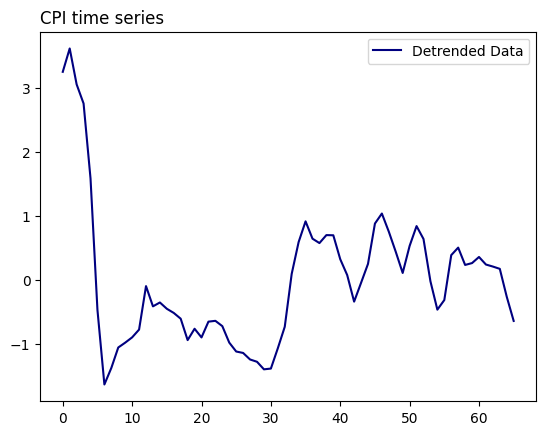

In [14]:
if x == 'linear':
    remaining = cpi_train.CPI - linear_cpi

    linear_cpi_test = model.predict(np.array(cpi_test.index).reshape(-1, 1))

    remaining = cpi_train.CPI - linear_cpi

    linear_cpi_test = model.predict(np.array(cpi_test.index).reshape(-1, 1))

    remaining_test = cpi_test.CPI - linear_cpi_test

    test = cpi_test.index

    train = cpi_train.index

else:
    cpi_diff = np.log(cpi.CPI).diff()

    remaining = cpi_diff[0 : cpi_train.shape[0]]

    remaining.iloc[0] = 0

    remaining_test = cpi_diff[cpi_train.shape[0]:].dropna()

    remaining_test.iloc[0] = 0

    test = cpi_test.index

    train = cpi_train.index

plt.plot(train, remaining, color = "navy", label = 'Detrended Data')

plt.title('CPI time series', loc = 'left')

plt.legend(loc = 'upper right')

plt.show()

Note that, at some stage, we will be required to add the trend back to the data. The function rebuild_diffed() below has been designed for this purpose. We will be calling this function later.

In [15]:
# Let us now create a function that would add the trend back

def rebuild_diffed(series, first_element_original, x, linear_trend):
    if x == 'linear':
        final = series + linear_trend

    else:
        cumsum = pd.Series(series).cumsum()

        final = np.exp(cumsum.fillna(0) + first_element_original)

        if first_element_original == 0:
            final = np.exp(cumsum.fillna(0))

    return final

As there seems to be no other trend present in this residual, we can take the linear trend to be sufficient and move to the next step, i.e., to deseasonalize the data. However, the above visualization seems to indicate no clear seasonality. Hence, we directly proceed to fit an AR Model on the residual. To do so, we first plot the autocorrelation and partial autocorrelation plots.

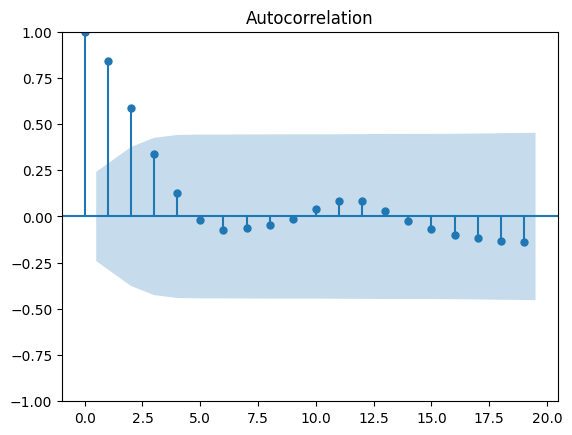

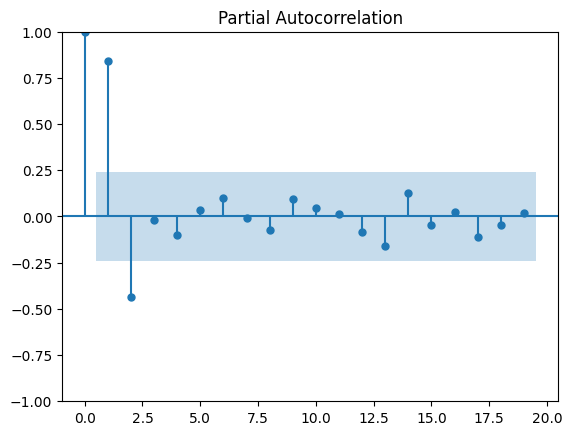

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(remaining)

plt.show()

plot_pacf(remaining)

plt.show()

From the above PACF plot, we can see that the highest lag at which the plot extends beyond the statistically
significant boundary is at lag 2. This indicates that an AR Model of lag 2 should be sufficient to fit the data.
However, we can further verify this by calculating the rmse of the fit

Test RMSE for AR(1):0.3953932977839376
Test RMSE for AR(2):0.4213968147033298
Test RMSE for AR(3):0.4052614560873436
Test RMSE for AR(4):0.4746821646771558
Test RMSE for AR(5):0.4596989307247372


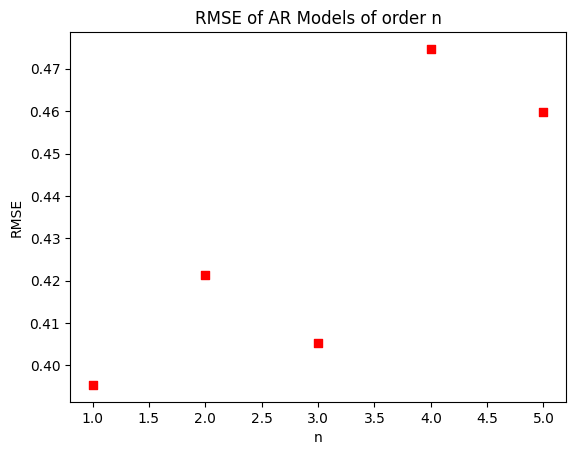

In [17]:
from statsmodels.tsa.ar_model import AutoReg

from sklearn.metrics import mean_squared_error

n = 2

rmse_ar = []

for n in range(1, 6):
    model = AutoReg(remaining, lags = n)

    model_fit = model.fit()

    coef = model_fit.params

    past = remaining[len(remaining) - n:].values

    past = [past[i] for i in range(len(past))]

    test_predictions = list()

    for t in range(len(remaining_test)):
        length = len(past)

        lag = [past[i] for i in range(length - n, length)]

        pred = coef[0]

        for d in range(n):

            pred += coef[d+1] * lag[n - d - 1]

        obs = remaining_test.values[t]

        test_predictions.append(pred)

        past.append(obs)

    rmse = (mean_squared_error(remaining_test, test_predictions)) ** 0.5

    rmse_ar.append(rmse)

    print('Test RMSE for AR(' + str(n) +'):' + str(rmse))

plt.scatter(np.arange(1,6), rmse_ar,marker = "s", color = 'red')

plt.xlabel("n")

plt.ylabel("RMSE")

plt.title("RMSE of AR Models of order n")

plt.show()

The plot above seems to indicate the AR(1) model predictions have the least rmse. While it would have been ideal to have our previous conclusion of the model order of 2 validated by the RMSE, we should note this kind of discrepancy between the two diagnostic methods (rmse and PACF) can occur when working with finite data sets. To proceed, we choose to work with the model order of 2 so we do not miss out on possible lag terms.

In [18]:
## Building the AR(2) Model
n = 2

AR2_model = AutoReg(remaining, lags = n).fit()

coef = AR2_model.params

# Walk forward over time steps in test
past = remaining[len(remaining)-n:].values

past = [past[i] for i in range(len(past))]

test_predictions = list()

training_predictions = AR2_model.predict(start = train[0], end = train[-1])

for t in range(len(remaining_test)):
    length = len(past)

    lag = [past[i] for i in range(length - n , length)]

    pred = coef[0]

    for d in range(n):
        pred += coef[d+1] * lag[n-d-1]

    obs = remaining_test.values[t]

    test_predictions.append(pred)

    past.append(obs)

final_training = (rebuild_diffed(training_predictions, np.log(cpi_train.CPI[0]), x, linear_cpi))

final_test = (rebuild_diffed(test_predictions, np.log(cpi_train.iloc[-1].CPI), x, linear_cpi_test))

We now plot the final model predictions and the actual observed data together to visualize the fit.

Text(0.5, 1.0, 'CPI predictions')

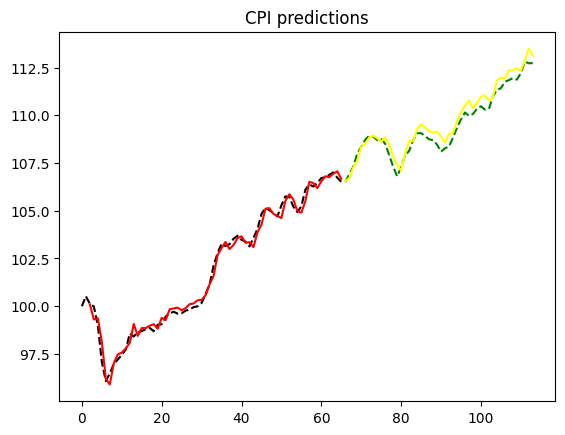

In [19]:
plt.plot(cpi_train.index, cpi_train.CPI, color = 'black', linestyle = 'dashed', label = 'Training')

plt.plot(cpi_test.index, cpi_test.CPI, color = 'green', linestyle = 'dashed', label = 'Test')

plt.plot(cpi_train.index, final_training, color = 'red', label = 'Final AF')

plt.plot(cpi_test.index, final_test, color = 'yellow', label = 'Final AF')

plt.title("CPI predictions")

We see that the AR(2) Model does predict pretty well, and the mean squared prediction error is small. We can also reaffirm this conclusion by plotting the residuals after the AR(2) predictions are subtracted from the detrended data

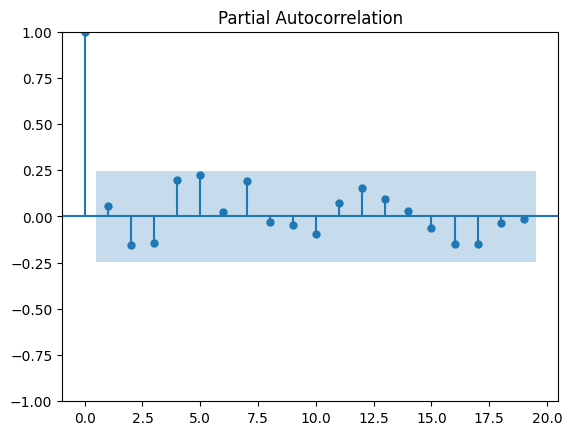

In [20]:
residuals = (remaining - training_predictions)[2:]

# Print(residuals)
plot_pacf(residuals)

plt.show()

In [21]:
rmse = mean_squared_error(cpi_test.CPI,final_test) ** 0.5

print("The rmse of the final fit is " + str(rmse))

The rmse of the final fit is 0.42139681470333024


### **Example 1 - AR(1)**

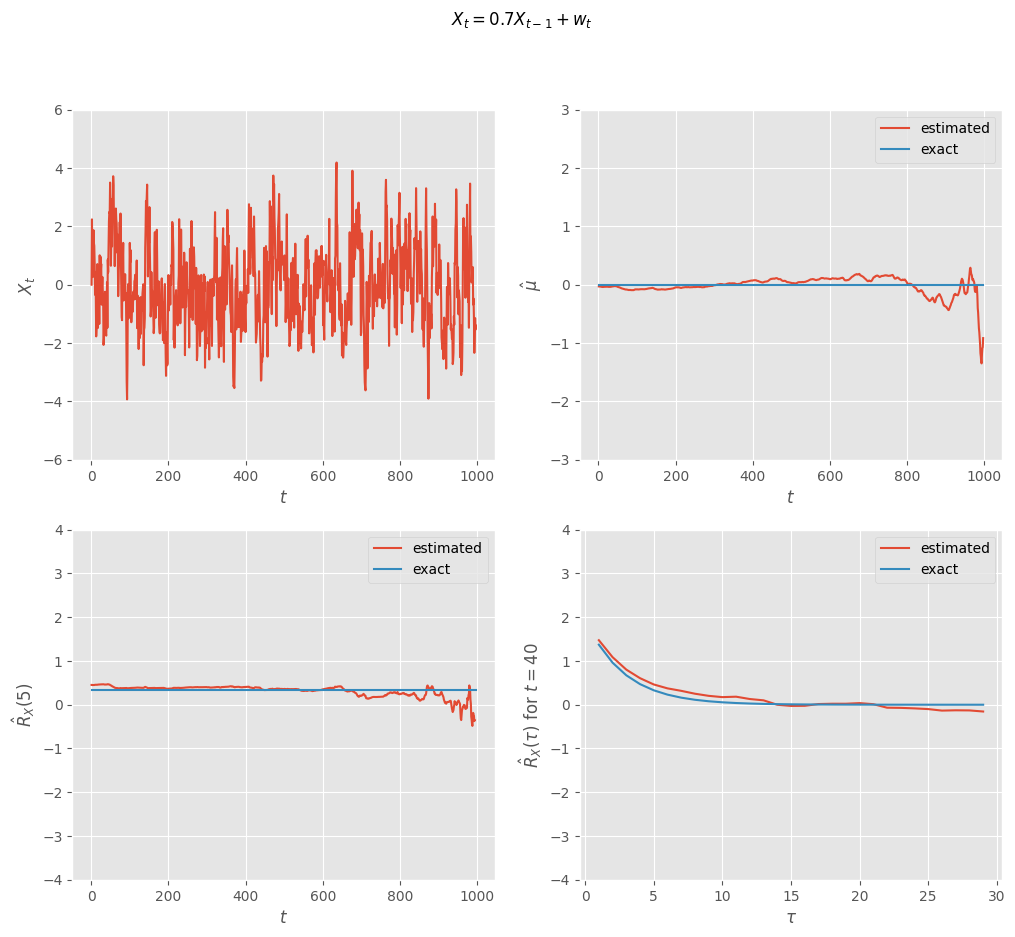

In [22]:
# Example 1

import numpy as np

np.random.seed(0)

import matplotlib.pyplot as plt

plt.style.use('ggplot')

X = [0, 0]

xt = X[0]

N = 1000

a = [0.7, 0.]

wtm1 = np.random.normal(0, 1)

wtm2 = np.random.normal(0, 1)

for t in range(N-2):
    wt = np.random.normal(0, 1)

    # xt = 0.7*X[-1] + np.random.normal(0, 1)
    xt = a[0] * X[-1] + np.random.normal(0, 1)

    # xt = wt + 0.5*wtm1 - 0.7*wtm2
    # xt = 0.7*X[-1] + 0.1*X[-2] + wt + 0.5*wtm1 - 0.7 * wtm2
    X.append(xt)

    wtm2 = wtm1

    wtm1 = wt

X = np.array(X)

ts = list(range(1, N-2, 1))

mus = [np.mean(X[t:]) for t in ts]

taus = list(range(1, 30))

def Rx(tau, t = 0):

    mu = np.mean(X[t:])

    return np.mean((X[t : -tau]-mu) * (X[t + tau:] - mu))

def exactRx2(taus, a1, a2, sigma):

    M = np.array([[1, -a1, -a2], [-a1, 1-a2, 0], [-a2, -a1, 1]])

    S = np.array([sigma, 0, 0])

    Rx = list(np.linalg.inv(M)@S.T)

    for tau in range(taus[-1]-2):
        Rx.append(Rx[-1] * a1 + Rx[-2] * a2)

    return Rx


fig, (ax1, ax2) = plt.subplots(2,2,figsize = (12, 10))

fig.suptitle('$X_t = 0.7X_{t-1} + w_t$')

ax1[0].plot(ts, X[ts], '-')

ax1[0].set_ylim(-6, 6)

ax1[0].set_xlabel('$t$')

ax1[0].set_ylabel('$X_t$')

ax1[1].plot(ts, mus, '-', label = "estimated")

ax1[1].plot(ts, np.zeros_like(ts), '-', label = "exact")

ax1[1].set_ylim(-3, 3)

ax1[1].legend()

ax1[1].set_ylabel('$\hat{\mu}$')

ax1[1].set_xlabel('$t$')

ax2[0].plot(ts, [Rx(5, t) for mu, t in zip(mus, ts)], '-', label = "estimated")

ax2[0].plot(ts, exactRx2(taus, a[0], a[1], 1)[5] * np.ones_like(ts), '-', label = "exact")

ax2[0].set_ylim(-4, 4)

ax2[0].legend()

ax2[0].set_ylabel('$\hat{R}_X(5)$')

ax2[0].set_xlabel('$t$')

ax2[1].plot(taus, [Rx(tau, 40) for tau in taus], '-', label = "estimated")

ax2[1].plot(taus, exactRx2(taus, a[0], a[1], 1)[1:], '-', label = "exact")

ax2[1].set_ylim(-4, 4)

ax2[1].legend()

ax2[1].set_ylabel('$\hat{R}_X(\\tau)$ for $t=' + str(40) + '$')

ax2[1].set_xlabel('$\\tau$')

plt.show()

### **Example 2 - AR(2)**

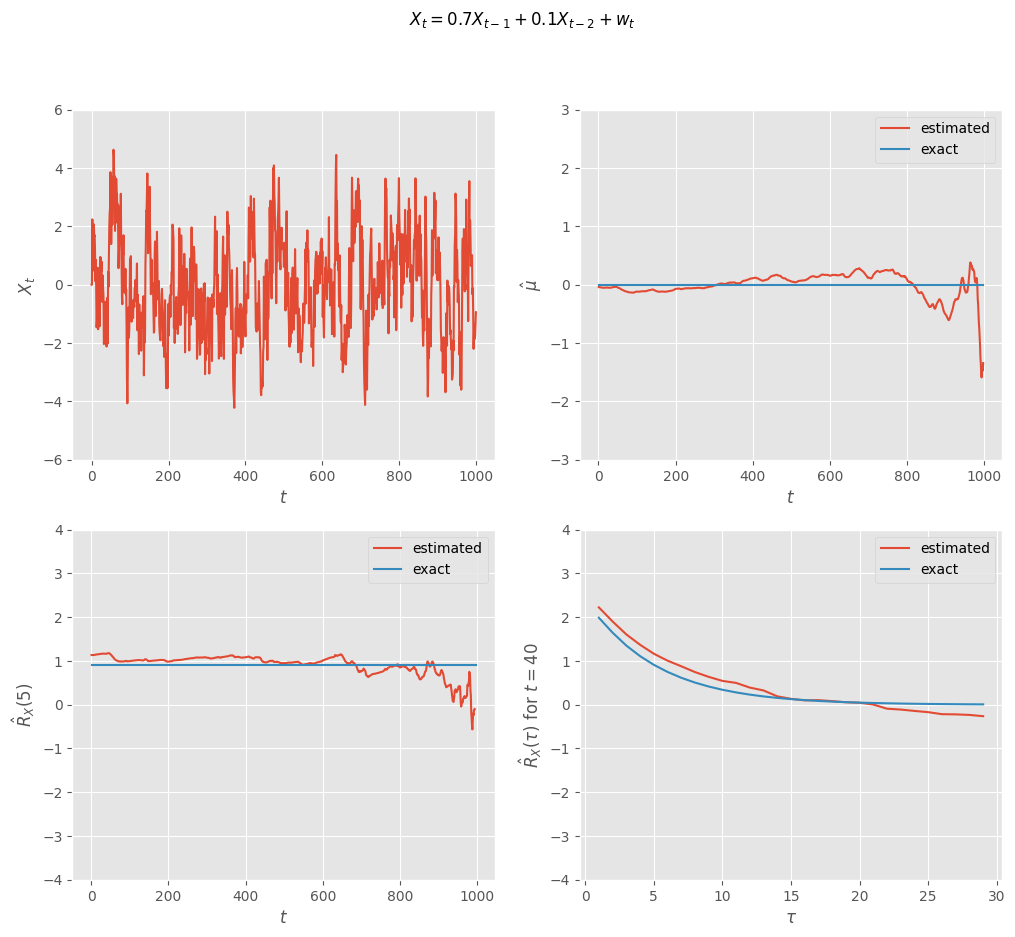

In [23]:
# Example 2
import numpy as np

np.random.seed(0)

import matplotlib.pyplot as plt

plt.style.use('ggplot')

X = [0, 0]

xt = X[0]

N = 1000

a = [0.7, 0.1]

wtm1 = np.random.normal(0, 1)

wtm2 = np.random.normal(0, 1)

for t in range(N-2):
    wt = np.random.normal(0, 1)

    # xt = 0.7*X[-1] + np.random.normal(0, 1)
    xt = a[0]*X[-1] + a[1] * X[-2] + np.random.normal(0, 1)

    # xt = wt + 0.5*wtm1 - 0.7*wtm2
    # xt = 0.7*X[-1] + 0.1*X[-2]+ wt + 0.5*wtm1 - 0.7*wtm2
    X.append(xt)

    wtm2 = wtm1

    wtm1 = wt

X = np.array(X)

ts = list(range(1, N-2, 1))

mus = [np.mean(X[t:]) for t in ts]

taus = list(range(1, 30))

def Rx(tau, t = 0):
    mu = np.mean(X[t:])

    return np.mean((X[t : -tau] - mu) * (X[t + tau:] - mu))

def exactRx2(taus, a1, a2, sigma):
    M = np.array([[1, -a1, -a2], [-a1, 1-a2, 0], [-a2, -a1, 1]])

    S = np.array([sigma, 0, 0])

    Rx = list(np.linalg.inv(M)@S.T)

    for tau in range(taus[-1] - 2):
        Rx.append(Rx[-1] * a1 + Rx[-2] * a2)

    return Rx


fig, (ax1, ax2) = plt.subplots(2, 2, figsize = (12, 10))

fig.suptitle('$X_t = 0.7X_{t-1} + 0.1X_{t-2} + w_t$')

ax1[0].plot(range(N), X, '-')

ax1[0].set_ylim(-6, 6)

ax1[0].set_xlabel('$t$')

ax1[0].set_ylabel('$X_t$')

ax1[1].plot(ts, mus, '-', label = "estimated")

ax1[1].plot(ts, np.zeros_like(ts), '-', label = "exact")

ax1[1].set_ylim(-3, 3)

ax1[1].legend()

ax1[1].set_ylabel('$\hat{\mu}$')

ax1[1].set_xlabel('$t$')

ax2[0].plot(ts, [Rx(5, t) for mu, t in zip(mus, ts)], '-', label = "estimated")

ax2[0].plot(ts, exactRx2(taus, a[0], a[1], 1)[5] * np.ones_like(ts), '-', label = "exact")

ax2[0].set_ylim(-4, 4)

ax2[0].legend()

ax2[0].set_ylabel('$\hat{R}_X(5)$')

ax2[0].set_xlabel('$t$')

ax2[1].plot(taus, [Rx(tau, 40) for tau in taus], '-', label = "estimated")

ax2[1].plot(taus, exactRx2(taus, a[0], a[1], 1)[1:], '-', label = "exact")

ax2[1].set_ylim(-4, 4)

ax2[1].legend()

ax2[1].set_ylabel('$\hat{R}_X(\\tau)$ for $t=' + str(40) + '$')

ax2[1].set_xlabel('$\\tau$')

plt.show()

### **Example 3 - MA(2) with more samples**

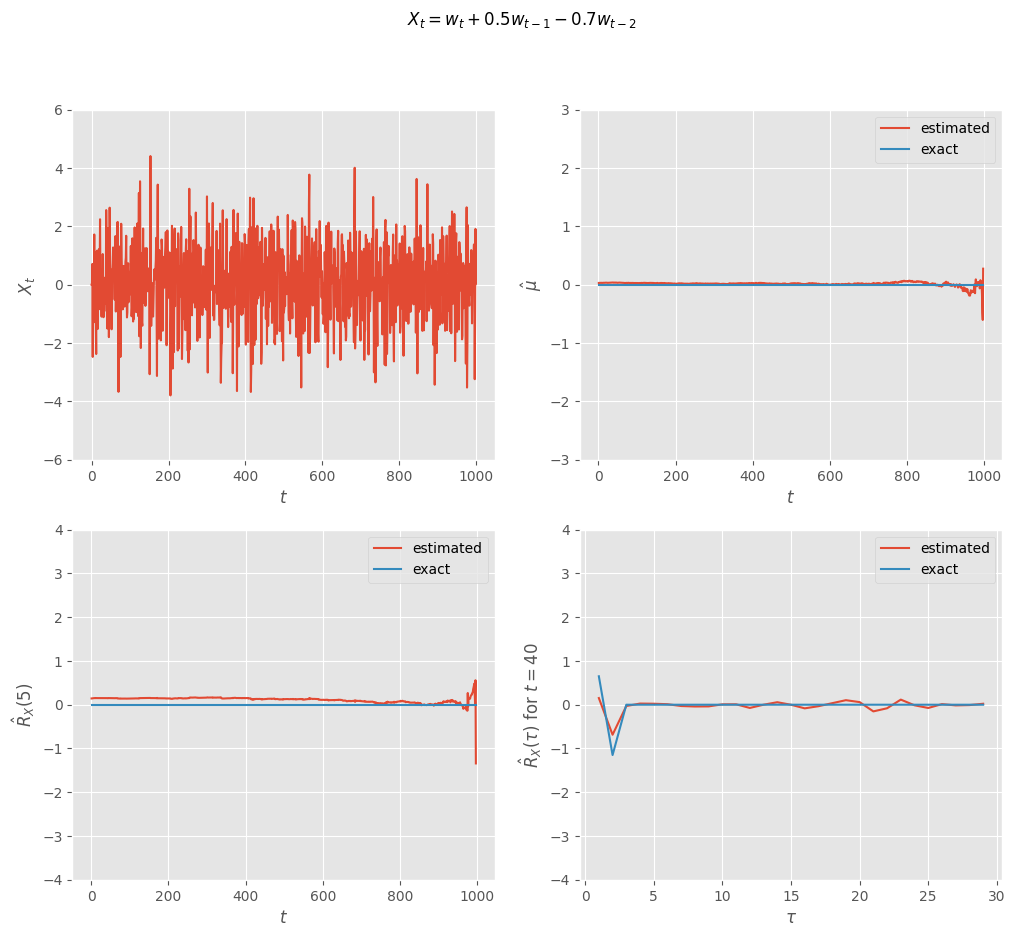

In [24]:
# Example 3
import numpy as np

np.random.seed(1)

import matplotlib.pyplot as plt

plt.style.use('ggplot')

X = [0, 0]

xt = X[0]

N = 1000

b = [1, 0.5, -0.7]

wtm1 = np.random.normal(0, 1)

wtm2 = np.random.normal(0, 1)

for t in range(N-2):
    wt = np.random.normal(0, 1)

    # xt = 0.7*X[-1] + np.random.normal(0, 1)
    # xt = a[0]*X[-1] + np.random.normal(0, 1)
    xt = b[0] * wt + b[1] * wtm1 + b[2] * wtm2

    # xt = 0.7*X[-1] + 0.1*X[-2]+ wt + 0.5*wtm1 - 0.7 * wtm2
    X.append(xt)

    wtm2 = wtm1

    wtm1 = wt

X = np.array(X)

ts = list(range(1, N-2, 1))

mus = [np.mean(X[t:]) for t in ts]

taus = list(range(1, 30))

def Rx(tau, t = 0):
    mu = np.mean(X[t:])

    return np.mean((X[t : -tau] - mu) * (X[t + tau:] - mu))

def exactRx(tau, b, sigma):
    if tau >= len(b): return 0

    else:
        return sum([b[j] * b[abs(j - tau)] for j in range(len(b))])


fig, (ax1, ax2) = plt.subplots(2,2,figsize = (12, 10))

fig.suptitle('$X_t=w_t+0.5w_{t-1}-0.7w_{t-2}$')

ax1[0].plot(range(N), X, '-')

ax1[0].set_ylim(-6, 6)

ax1[0].set_xlabel('$t$')

ax1[0].set_ylabel('$X_t$')

ax1[1].plot(ts, mus, '-', label = "estimated")

ax1[1].plot(ts, np.zeros_like(ts), '-', label = "exact")

ax1[1].set_ylim(-3, 3)

ax1[1].legend()

ax1[1].set_ylabel('$\hat{\mu}$')

ax1[1].set_xlabel('$t$')

ax2[0].plot(ts, [Rx(1, t) for mu, t in zip(mus, ts)], '-', label = "estimated")

ax2[0].plot(ts, exactRx(5, b, 1) * np.ones_like(ts), '-', label = "exact")

ax2[0].set_ylim(-4, 4)

ax2[0].legend()

ax2[0].set_ylabel('$\hat{R}_X(5)$')

ax2[0].set_xlabel('$t$')

ax2[1].plot(taus, [Rx(tau, 40) for tau in taus], '-', label = "estimated")

ax2[1].plot(taus, [exactRx(tau, b, 1) for tau in taus], '-', label = "exact")

ax2[1].set_ylim(-4, 4)

ax2[1].legend()

ax2[1].set_ylabel('$\hat{R}_X(\\tau)$ for $t=' + str(40) + '$')

ax2[1].set_xlabel('$\\tau$')

plt.show()


### **Example 4 - ARMA with more samples**

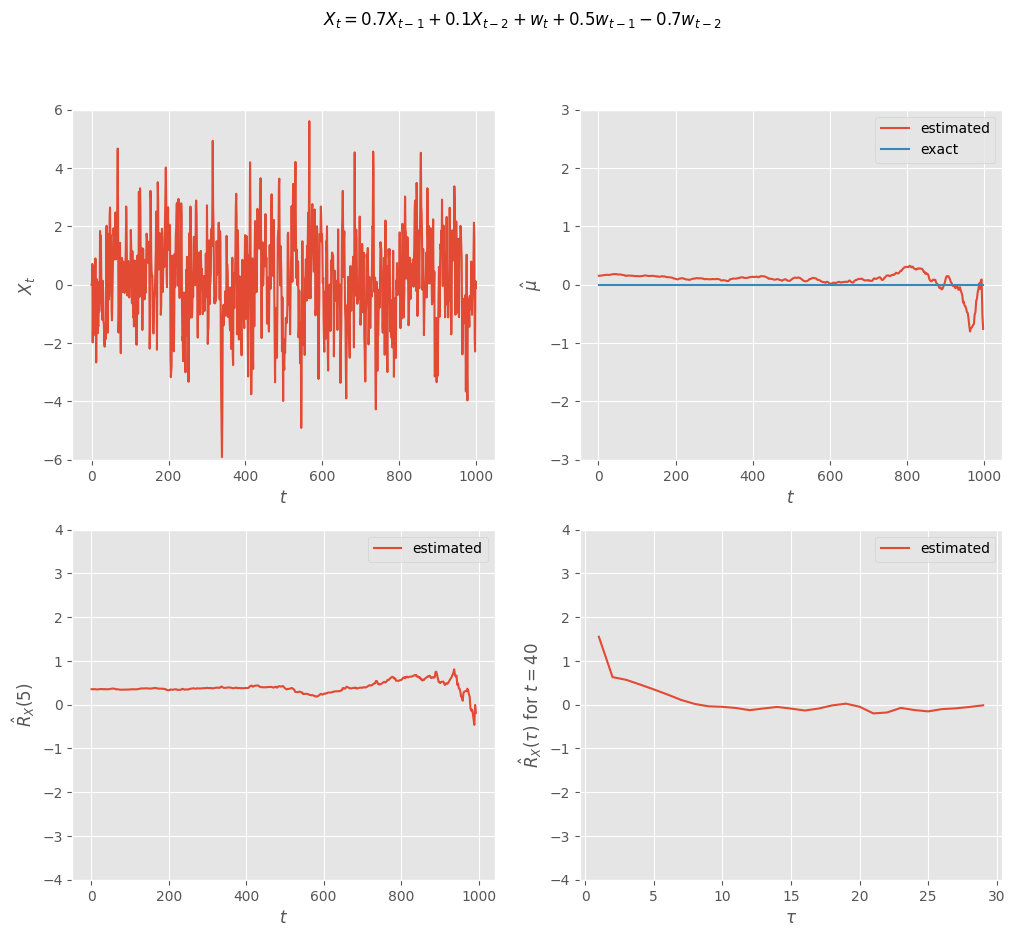

In [25]:
# Example 4
import numpy as np

np.random.seed(1)

import matplotlib.pyplot as plt

plt.style.use('ggplot')

X = [0, 0]

xt = X[0]

N = 1000

b = [1, 0.5, -0.7]

wtm1 = np.random.normal(0, 1)

wtm2 = np.random.normal(0, 1)

for t in range(N-2):
    wt = np.random.normal(0, 1)

    xt = 0.7 * X[-1] + 0.1 * X[-2] + wt + .5 * wtm1 - .7 * wtm2

    X.append(xt)

    wtm2 = wtm1

    wtm1 = wt

X = np.array(X)

ts = list(range(1, N-2, 2))

mus = [np.mean(X[t:]) for t in ts]

taus = list(range(1, 30))

def Rx(tau, t = 0):
    mu = np.mean(X[t:])

    return np.mean((X[t : -tau] - mu) * (X[t + tau:] - mu))

fig, (ax1, ax2) = plt.subplots(2,2,figsize = (12, 10))

fig.suptitle('$X_t=0.7X_{t-1} + 0.1X_{t-2}+ w_t+0.5w_{t-1} - 0.7w_{t-2}$')

ax1[0].plot(range(N), X, '-')

ax1[0].set_ylim(-6, 6)

ax1[0].set_xlabel('$t$')

ax1[0].set_ylabel('$X_t$')

ax1[1].plot(ts, mus, '-', label = "estimated")

ax1[1].plot(ts, np.zeros_like(ts), '-', label = "exact")

ax1[1].set_ylim(-3, 3)

ax1[1].legend()

ax1[1].set_ylabel('$\hat{\mu}$')

ax1[1].set_xlabel('$t$')

ax2[0].plot(ts, [Rx(5, t) for mu, t in zip(mus, ts)], '-', label = "estimated")

ax2[0].legend()

ax2[0].set_ylim(-4, 4)

ax2[0].set_ylabel('$\hat{R}_X(5)$')

ax2[0].set_xlabel('$t$')

ax2[1].plot(taus, [Rx(tau, 40) for tau in taus], '-', label = "estimated")

ax2[1].legend()

ax2[1].set_ylim(-4, 4)

ax2[1].set_ylabel('$\hat{R}_X(\\tau)$ for $t=' + str(40) + '$')

ax2[1].set_xlabel('$\\tau$')

plt.show()

## **Estimating parameters of ARMA(1) with data from example 2**

## **MLE**


In [26]:
import numpy as np

import scipy as sp

from scipy.stats import norm

np.random.seed(0)

import matplotlib.pyplot as plt

plt.style.use('ggplot')

X = [0, 0]

xt = X[0]

N = 1000

a = [0.7, 0.1]

for t in range(N - 2):

    wt = np.random.normal(0, 1)

    xt = a[0] * X[-1] + wt + a[1] * X[-2]

    X.append(xt)

X = np.array(X)

print(f"True a : {a}")

XtdotXtm1 = X[1:]@X[:-1]

Xtm1dotXtm1 = X[:-1]@X[:-1]

print(f"ARMA(1) MLE a:{XtdotXtm1 / Xtm1dotXtm1: > .4f}")

A = X[:-1].reshape(-1, 1)

b = X[1:]

a_est = np.linalg.inv(A.T@A)@A.T@b

print(f"ARMA(1) Least square a:{a_est[0]: > .4f}")

A = np.array([X[1:-1], X[:-2]]).T

b = X[2:].reshape(-1, 1)

a_est = np.round(np.linalg.inv(A.T@A)@A.T@b, 4)

print(f"ARMA(2) Least square a:{a_est.T[0]}")

True a : [0.7, 0.1]
ARMA(1) MLE a: 0.7926
ARMA(1) Least square a: 0.7926
ARMA(2) Least square a:[0.6771 0.1457]
